In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
import numpy as np 
from collections import deque
from keras.models import load_model
import random
import matplotlib.pyplot as plt
import gym
from gym import wrappers

In [7]:
class AI():
    def __init__(self, state_size, action_size, memory_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = memory_size)
        

        # HYPERPARAMETER
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon  = 0.5
        self.epsilon_start = self.epsilon

        self.brain = self.build_brain()


    def build_brain(self):
        model = Sequential()
        model.add(Dense(self.state_size, activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(25, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss = "mse", optimizer = RMSprop(lr=self.learning_rate))
        return model


    def load_model(self, name):
        """
        Loads an existing Model
        Input: string of the model name - h5 data
        """
        brain = load_model(name)
        return None

    def save_learnings(self, model_name):#
        """
        Input string of Modelname
        """
        self.brain.save(model_name+".h5")
    
    def adapt_epsilon(self,ep):
        # Epsilon starts at 0.5 linear increasing to 0.99 by ep 4000:
        # linear: epsilon = 0.0001225*ep+self.epsilon_start
        # exponent (4000 eps): epsilon = self.epsilon_start + (ep/5714)**2
        if ep == 0:
            pass
        self.epsilon = self.epsilon_start + (ep/5714)**2 
    
    def act(self, state, status = "train"):
        if status == "train": 
            if np.random.rand() > self.epsilon:
                return random.randrange(self.action_size)
        return np.argmax(self.brain.predict(state)[0]) 
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size) 
        for state, action, reward, next_state, done in samples:
            target = reward
            
            if not done:    
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # Predict the future/target value
                #print(target)
            Q_target_shape = self.brain.predict(state) # normal Q- Value prediction for the training-shape 
            Q_target_shape[0][action] = target # replacing the best Q-Value with the target 
            self.brain.fit(state, Q_target_shape, epochs=1, verbose=0) # training with the new Target value (loss = sum(Q_target-Q)exp2)

    

In [8]:
import time
start_time = time.time()

def play(Ep, agent, status = "train"):
    
    learning_graph = []
    env = gym.make("Boxing-ram-v0")
    env = wrappers.Monitor(env, "Saved_DQN_ER_Models/", resume=True, video_callable=lambda episode_id: episode_id%250==0)
    action_space = env.action_space.n 
    state_space = env.observation_space.shape[0]
    if agent == None:
        agent = AI(state_space,action_space,memory_size = 5000,learning_rate = 0.001,gamma = 0.95) #2500 mem
    for ep in range(Ep):
        state = env.reset()
        state = np.reshape(state,[1,state_space]) 
        done = False
        score = 0
        agent.adapt_epsilon(ep) # Increasing the epsilon linear - adjustable to non linear, log,...
        while not done:

            if status == "play":
                env.render()
            action = agent.act(state, status)
            new_state, reward, done, _ = env.step(action)
            new_state  = np.reshape(new_state,[1,state_space])
            agent.remember(state, action, reward, new_state, done)
            state = new_state
            score +=1
            if done:
                break
        print("Episode {}# Score: {}".format(ep, score + 1), "Episode time: {}".format(time.strftime("%Mm %Ss", time.gmtime(time.time()-start_time))))
        if ep == 250 or ep % 500 == 0:
                # save model eacht 500 ep for videos
                agent.save_learnings(str(ep)+","+str(score))
        agent.replay() 
        learning_graph.append(score)
    return learning_graph, agent

In [9]:
def main():
    Episodes = 1000 #4001
    graph,agent = play(Episodes,None)
    plt.plot(graph)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

    print("Do you want to save the model?")
    answer = input("Y/N\n")
    if answer == "Y":
        name = input("give a name for the model: \n")
        agent.save_learnings(name)
    else:
        pass
    

    #print("Soll der Agent getestet werden?\n")
    #n = input("Wie viele Episoden sollen gespielt werden?")
    #x,y = play(int(n),agent,status = "play")


Episode 0# Score: 2390 Episode time: 00m 44s
Episode 1# Score: 2403 Episode time: 00m 49s
Episode 2# Score: 2362 Episode time: 00m 54s
Episode 3# Score: 2397 Episode time: 00m 59s
Episode 4# Score: 2378 Episode time: 01m 04s
Episode 5# Score: 2369 Episode time: 01m 09s
Episode 6# Score: 2389 Episode time: 01m 14s
Episode 7# Score: 2398 Episode time: 01m 19s
Episode 8# Score: 2371 Episode time: 01m 24s
Episode 9# Score: 2348 Episode time: 01m 28s
Episode 10# Score: 2381 Episode time: 01m 33s
Episode 11# Score: 2411 Episode time: 01m 38s
Episode 12# Score: 2368 Episode time: 01m 43s
Episode 13# Score: 2374 Episode time: 01m 48s
Episode 14# Score: 2376 Episode time: 01m 53s
Episode 15# Score: 2368 Episode time: 01m 58s
Episode 16# Score: 2380 Episode time: 02m 03s
Episode 17# Score: 2396 Episode time: 02m 08s
Episode 18# Score: 2378 Episode time: 02m 13s
Episode 19# Score: 2368 Episode time: 02m 17s
Episode 20# Score: 2377 Episode time: 02m 22s
Episode 21# Score: 2409 Episode time: 02m 27

Episode 177# Score: 2401 Episode time: 15m 01s
Episode 178# Score: 2389 Episode time: 15m 06s
Episode 179# Score: 2377 Episode time: 15m 11s
Episode 180# Score: 2384 Episode time: 15m 16s
Episode 181# Score: 2384 Episode time: 15m 21s
Episode 182# Score: 2427 Episode time: 15m 26s
Episode 183# Score: 2371 Episode time: 15m 30s
Episode 184# Score: 2373 Episode time: 15m 35s
Episode 185# Score: 2391 Episode time: 15m 40s
Episode 186# Score: 2377 Episode time: 15m 45s
Episode 187# Score: 2404 Episode time: 15m 50s
Episode 188# Score: 2381 Episode time: 15m 55s
Episode 189# Score: 2383 Episode time: 15m 59s
Episode 190# Score: 2413 Episode time: 16m 04s
Episode 191# Score: 2389 Episode time: 16m 09s
Episode 192# Score: 2383 Episode time: 16m 14s
Episode 193# Score: 2390 Episode time: 16m 19s
Episode 194# Score: 2397 Episode time: 16m 24s
Episode 195# Score: 2376 Episode time: 16m 28s
Episode 196# Score: 2387 Episode time: 16m 33s
Episode 197# Score: 2390 Episode time: 16m 38s
Episode 198# 

Episode 352# Score: 2375 Episode time: 29m 14s
Episode 353# Score: 2358 Episode time: 29m 19s
Episode 354# Score: 2364 Episode time: 29m 24s
Episode 355# Score: 2362 Episode time: 29m 29s
Episode 356# Score: 2377 Episode time: 29m 34s
Episode 357# Score: 2386 Episode time: 29m 39s
Episode 358# Score: 2385 Episode time: 29m 43s
Episode 359# Score: 2380 Episode time: 29m 48s
Episode 360# Score: 2348 Episode time: 29m 53s
Episode 361# Score: 2381 Episode time: 29m 58s
Episode 362# Score: 2380 Episode time: 30m 03s
Episode 363# Score: 2377 Episode time: 30m 08s
Episode 364# Score: 2400 Episode time: 30m 12s
Episode 365# Score: 2368 Episode time: 30m 17s
Episode 366# Score: 2406 Episode time: 30m 22s
Episode 367# Score: 2357 Episode time: 30m 27s
Episode 368# Score: 2367 Episode time: 30m 32s
Episode 369# Score: 2381 Episode time: 30m 37s
Episode 370# Score: 2387 Episode time: 30m 41s
Episode 371# Score: 2380 Episode time: 30m 46s
Episode 372# Score: 2375 Episode time: 30m 51s
Episode 373# 

Episode 527# Score: 2366 Episode time: 43m 21s
Episode 528# Score: 2394 Episode time: 43m 26s
Episode 529# Score: 2369 Episode time: 43m 31s
Episode 530# Score: 2394 Episode time: 43m 36s
Episode 531# Score: 2388 Episode time: 43m 41s
Episode 532# Score: 2379 Episode time: 43m 45s
Episode 533# Score: 2388 Episode time: 43m 50s
Episode 534# Score: 2394 Episode time: 43m 55s
Episode 535# Score: 2386 Episode time: 44m 00s
Episode 536# Score: 2389 Episode time: 44m 05s
Episode 537# Score: 2383 Episode time: 44m 10s
Episode 538# Score: 2370 Episode time: 44m 14s
Episode 539# Score: 2378 Episode time: 44m 19s
Episode 540# Score: 2372 Episode time: 44m 24s
Episode 541# Score: 2402 Episode time: 44m 29s
Episode 542# Score: 2380 Episode time: 44m 34s
Episode 543# Score: 2370 Episode time: 44m 39s
Episode 544# Score: 2374 Episode time: 44m 43s
Episode 545# Score: 2364 Episode time: 44m 48s
Episode 546# Score: 2382 Episode time: 44m 53s
Episode 547# Score: 2352 Episode time: 44m 58s
Episode 548# 

Episode 702# Score: 2371 Episode time: 57m 28s
Episode 703# Score: 2377 Episode time: 57m 32s
Episode 704# Score: 2366 Episode time: 57m 37s
Episode 705# Score: 2374 Episode time: 57m 42s
Episode 706# Score: 2380 Episode time: 57m 47s
Episode 707# Score: 2367 Episode time: 57m 52s
Episode 708# Score: 2382 Episode time: 57m 57s
Episode 709# Score: 2410 Episode time: 58m 01s
Episode 710# Score: 2387 Episode time: 58m 06s
Episode 711# Score: 2392 Episode time: 58m 11s
Episode 712# Score: 2393 Episode time: 58m 16s
Episode 713# Score: 2389 Episode time: 58m 21s
Episode 714# Score: 2380 Episode time: 58m 26s
Episode 715# Score: 2380 Episode time: 58m 31s
Episode 716# Score: 2357 Episode time: 58m 35s
Episode 717# Score: 2374 Episode time: 58m 40s
Episode 718# Score: 2382 Episode time: 58m 45s
Episode 719# Score: 2391 Episode time: 58m 50s
Episode 720# Score: 2387 Episode time: 58m 55s
Episode 721# Score: 2372 Episode time: 59m 00s
Episode 722# Score: 2385 Episode time: 59m 04s
Episode 723# 

Episode 877# Score: 2391 Episode time: 11m 36s
Episode 878# Score: 2395 Episode time: 11m 41s
Episode 879# Score: 2387 Episode time: 11m 45s
Episode 880# Score: 2384 Episode time: 11m 50s
Episode 881# Score: 2361 Episode time: 11m 55s
Episode 882# Score: 2358 Episode time: 12m 00s
Episode 883# Score: 2374 Episode time: 12m 05s
Episode 884# Score: 2380 Episode time: 12m 10s
Episode 885# Score: 2390 Episode time: 12m 15s
Episode 886# Score: 2376 Episode time: 12m 19s
Episode 887# Score: 2365 Episode time: 12m 24s
Episode 888# Score: 2370 Episode time: 12m 29s
Episode 889# Score: 2366 Episode time: 12m 34s
Episode 890# Score: 2377 Episode time: 12m 39s
Episode 891# Score: 2364 Episode time: 12m 44s
Episode 892# Score: 2374 Episode time: 12m 48s
Episode 893# Score: 2375 Episode time: 12m 53s
Episode 894# Score: 2384 Episode time: 12m 58s
Episode 895# Score: 2387 Episode time: 13m 03s
Episode 896# Score: 2362 Episode time: 13m 08s
Episode 897# Score: 2367 Episode time: 13m 13s
Episode 898# 

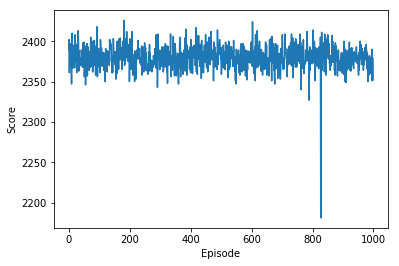

Do you want to save the model?
Y/N
RMS_1000


In [10]:
main()